In [1]:

import numpy as np

from collections import defaultdict
import copy

import sys
import os
import time
import datetime
import torch
import torchvision

import matplotlib.pyplot as plt
import torch.nn as nn



In [2]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:

#load pretrained model
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

#modify output layer for 2 classes - for this case the classes are regular frogs and noisy frogs
#but for the project it would be poisoned vs non-poisoned images
model.fc = torch.nn.Linear(num_ftrs, 2)



C:\Users\Pierland\anaconda3\envs\asparagus_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Pierland\anaconda3\envs\asparagus_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
#freeze earlier layers - this is optional and it may work better to NOT freeze the earlier layers
for param in model.parameters():
    param.requires_grad = False
    for name, param in model.named_parameters():
        if "fc" in name:
            param.requires_grad = True 


In [5]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.ImageFolder(root="data/noisy_vs_clean/train",transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root="data/noisy_vs_clean/train",transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)


EPOCHS=40
BATCH_SIZE = 64
TOTAL_SIZE = 9800
#TOTAL_TEST_SIZE = 
STEPS_PER_EPOCH = TOTAL_SIZE // BATCH_SIZE

TOTAL_TEST_SIZE = 200 
STEPS_PER_TEST_EPOCH = TOTAL_TEST_SIZE // BATCH_SIZE
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [6]:
trainset

Dataset ImageFolder
    Number of datapoints: 9800
    Root location: data/noisy_vs_clean/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
trainset.classes

['cleanfrog', 'realNoisyFrogs']

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  # Sending model to device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.0008
)  # lr should be kept low so that the pre-trained weights don't change easily

In [9]:
def get_test():
    test_loss = []
    correct = 0
    incorrect = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for batch_idx, (data, target) in enumerate(testloader):
        if batch_idx == STEPS_PER_TEST_EPOCH:
            break

        # Model is used to predict the test data so we are switching off the gradient

        with torch.no_grad():

            data = data.to(device)
            target = target.long().to(device)
            output = model(data)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, target)

            # Note that optimizer is not used because the model shouldn't learn the test dataset

            for i in range(BATCH_SIZE):
                a = []
                for j in output[i]:
                    a.append(float(j.detach()))

                pred = a.index(max(a))

                if pred == int(target[i]):
                    correct = correct + 1

                else:
                    incorrect = incorrect + 1

        test_loss.append(float(loss.detach()))
    print("CORRECT: " + str(correct), "INCORRECT: " + str(incorrect),"TEST ACCURACY: "+str(correct/(correct+incorrect)))
    return (
            correct/(incorrect+correct),
            sum(test_loss)/len(test_loss),
    )

In [10]:
acc_ , loss_ = get_test()
print("ACCURACY AND LOSS BEFORE TUNING")
print("ACCURACY : "+str(acc_),"LOSS : "+str(loss_))

CORRECT: 96 INCORRECT: 96 TEST ACCURACY: 0.5
ACCURACY AND LOSS BEFORE TUNING
ACCURACY : 0.5 LOSS : 0.8132747809092203


In [11]:
avg_test_loss_history = []
avg_test_accuracy_history = []
avg_train_loss_history = []
avg_train_accuracy_history = []


loss_history = []
accuracy_history = []

new_best = 0

for i in range(EPOCHS):

    start = time.time()
    print(
        "-----------------------EPOCH "
        + str(i)
        + " -----------------------------------"
    )
    for batch_idx, (data, target) in enumerate(trainloader):
        if batch_idx == STEPS_PER_EPOCH:
            break
        optimizer.zero_grad()  # Resetting gradients after each optimizations
        # Sending input , target to device
        data = data.to(device) 
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape((BATCH_SIZE,)).long())
        loss_history.append(loss.detach())
        # The loss variable has gradient attached to it so we are removing it so that it can be used to plot graphs
        loss.backward()
        optimizer.step()  # Optimizing the model

        # Checking train accuracy

        correct = 0
        incorrect = 0
        for p in range(BATCH_SIZE):
            a = []
            for j in output[p]:
                a.append(float(j.detach()))

            pred = a.index(max(a))

            if pred == int(target[p]):
                correct = correct + 1

            else:

                incorrect = incorrect + 1

        print(
            "\r EPOCH "
            + str(i)
            + " MINIBATCH: "
            + str(batch_idx)
            + "/"
            + str(STEPS_PER_EPOCH)
            + " LOSS: "
            + str(loss_history[-1]),
            end = ""
            
        )
        
        accuracy_history.append(correct/(correct+incorrect))

    end = time.time()
    print(
        " \n EPOCH "
        + str(i)
        + " LOSS "
        + str(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
        + " ETA: "
        + str(end - start)
        + " \n MAX LOSS: "
        + str(max(loss_history[-STEPS_PER_EPOCH:]))
        + " MIN LOSS: "
        + str(min(loss_history[-STEPS_PER_EPOCH:]))
        + " TRAIN ACCURACY: "
        + str(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    )
    
    avg_train_loss_history.append(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    avg_train_accuracy_history.append(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)

    test_acc , test_loss  = get_test()
    
    avg_test_accuracy_history.append(test_acc)
    avg_train_loss_history.append(test_loss)
    
    if test_acc>new_best: 
        new_best = test_acc
        torch.save(model.state_dict(), "model_save/model.pth") # Saving our best model


-----------------------EPOCH 0 -----------------------------------
 EPOCH 0 MINIBATCH: 152/153 LOSS: tensor(0.7602, device='cuda:0') 
 EPOCH 0 LOSS tensor(0.7490, device='cuda:0') ETA: 7.9598305225372314 
 MAX LOSS: tensor(0.8873, device='cuda:0') MIN LOSS: tensor(0.6592, device='cuda:0') TRAIN ACCURACY: 0.5026552287581699
CORRECT: 100 INCORRECT: 92 TEST ACCURACY: 0.5208333333333334
-----------------------EPOCH 1 -----------------------------------
 EPOCH 1 MINIBATCH: 152/153 LOSS: tensor(0.6808, device='cuda:0') 
 EPOCH 1 LOSS tensor(0.7180, device='cuda:0') ETA: 7.6405675411224365 
 MAX LOSS: tensor(0.8527, device='cuda:0') MIN LOSS: tensor(0.6280, device='cuda:0') TRAIN ACCURACY: 0.5124591503267973
CORRECT: 100 INCORRECT: 92 TEST ACCURACY: 0.5208333333333334
-----------------------EPOCH 2 -----------------------------------
 EPOCH 2 MINIBATCH: 152/153 LOSS: tensor(0.7469, device='cuda:0') 
 EPOCH 2 LOSS tensor(0.7134, device='cuda:0') ETA: 8.148873329162598 
 MAX LOSS: tensor(0.7947

In [12]:
print("ACCURACY : ",new_best)

ACCURACY :  0.6041666666666666


<function matplotlib.pyplot.legend(*args, **kwargs)>

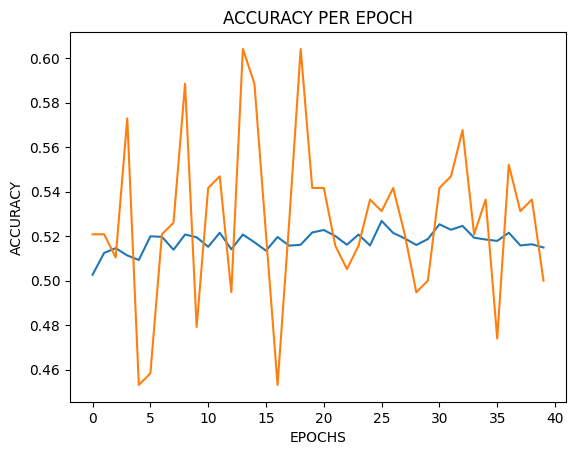

In [13]:
plt.plot(avg_train_accuracy_history , label = "Train")
plt.plot(avg_test_accuracy_history , label = "Test")
plt.title('ACCURACY PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend

In [14]:
from PIL import Image
# Directory with the images
DATA_DIR = "allfrog"
OUTPUT_FILE = "labels.txt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture (example: ResNet18)
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Adjust output layer to match the checkpoint
model.load_state_dict(torch.load("model_save/model.pth"))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Transformation for the images (match training preprocessing)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust size if needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Match training normalization
])

# Process images and determine labels
image_files = sorted(os.listdir(DATA_DIR))  # Sort filenames lexicographically
labels = []

for img_file in image_files:
    img_path = os.path.join(DATA_DIR, img_file)
    if not os.path.isfile(img_path):
        continue  # Skip non-file entries

    # Load and preprocess the image
    try:
        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    except Exception as e:
        print(f"Error loading image {img_file}: {e}")
        labels.append("bad")  # Assign a default label for failed images
        continue

    # Predict with the model
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    # Map the prediction to "good" or "bad"
    if predicted_class.item() == 0:  # Assuming 0 = "bad" and 1 = "good"
        labels.append("bad")
    else:
        labels.append("good")

# Save labels to labels.txt
with open(OUTPUT_FILE, "w") as f:
    for label in labels:
        f.write(f"{label}\n")

print(f"Labels saved ")


C:\Users\Pierland\AppData\Local\Temp\ipykernel_16368\2061122633.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_save/model.pth")

Labels saved 
